In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
import os
import time

import pandas as pd
import numpy as np
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm as tqdm

In [3]:
import sys

sys.path.append('..')
from src.configs import config
from src.configs.config import merge_opts, train_pix2pix_options, base_pix2pix_options
from src.modules.srgan import data_utils as ds
from src.modules.srgan.data_utils import HPATrainDatasetFromFolder, HPAValDatasetFromFolder, \
    RecursionTrainDatasetFromFolder, RecursionValDatasetFromFolder, ImageStacker

from src.modules.pix2pix.colorization_model import ColorizationModel

%load_ext autoreload
%autoreload 2

In [4]:
def merge_opts(opt1, opt2):
    return EasyDict({**opt1, **opt2})

In [5]:
def show_tensor(t, pixel_scale=100):
    img = np.transpose(t.numpy(), (1,2,0))
    f = plt.figure(figsize=(int(img.shape[1] / pixel_scale), int(img.shape[0] / pixel_scale)))
    plt.imshow(img, interpolation='nearest')
    plt.show()

In [6]:
def get_dataloaders(train_data_dir, valid_data_dir, opt):
    if opt.dataset_type == 'hpa':
        train_set = HPATrainDatasetFromFolder(
            train_data_dir, crop_size=opt.crop_size,
            upscale_factor=1, colorisation=True,
            merged_channels=opt.merged_channels,
            normalization=opt.dataset_norm)
        val_set = HPAValDatasetFromFolder(
            valid_data_dir, upscale_factor=1,
            colorisation=True,
            merged_channels=opt.merged_channels,
            normalization=opt.dataset_norm)
        
    elif opt.dataset_type == 'rx':
        train_set = RecursionTrainDatasetFromFolder(
            train_data_dir, crop_size=opt.crop_size,
            upscale_factor=1, colorisation=True, merged_channels=opt.merged_channels)
        val_set = RecursionValDatasetFromFolder(
            valid_data_dir, upscale_factor=1,
            colorisation=True, merged_channels=opt.merged_channels)
        
    else:
        raise ValueError('Unknown dataset type ' + dataset_type)
        
    train_loader = DataLoader(dataset=train_set, num_workers=opt.num_workers,
                              batch_size=opt.batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_set, num_workers=8, batch_size=1, shuffle=False)
    return train_loader, val_loader

def get_dataloaders_args(train_data_dir, valid_data_dir, **kwargs):
    return get_dataloaders(train_data_dir, valid_data_dir,
                           merge_opts(train_pix2pix_options, kwargs))

In [7]:
def train_pix2pix(train_data_dir, val_data_dir, **kwargs):
    opt = merge_opts(train_pix2pix_options, kwargs)
    opt.isTrain = True
    
    train_loader, val_loader = get_dataloaders(train_data_dir, val_data_dir, opt)
    
    model = ColorizationModel(opt)
    model.setup(opt)
    
    total_epochs = opt.niter + opt.niter_decay + 1
    total_iters = 0
    
    for epoch in range(opt.epoch_count, total_epochs):    # outer loop for different epochs; we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>
        model.train()
        poch_start_time = time.time()  # timer for entire epoch
        epoch_iter = 0                  # the number of training iterations in current epoch, reset to 0 every epoch
        train_bar = tqdm(train_loader)
        
        for i, (input_img, target_img) in enumerate(train_bar):  # inner loop within one epoch
            total_iters += opt.batch_size
            epoch_iter += opt.batch_size
            model.set_input({'A': input_img, 'B': target_img, 'A_paths': [], 'B_paths': []})         # unpack data from dataset and apply preprocessing
            model.optimize_parameters()   # calculate loss functions, get gradients, update network weights

#             if total_iters % opt.display_freq == 0:   # display images on visdom and save images to a HTML file
#                 save_result = total_iters % opt.update_html_freq == 0
#                 model.compute_visuals()
#                 visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

            losses = model.get_current_losses()
            train_bar.set_description(desc='[{}/{}] losses: {}'.format(epoch, total_epochs, losses))

            if total_iters % opt.save_latest_freq == 0:   # cache our latest model every <save_latest_freq> iterations
                print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
                save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
                model.save_networks(save_suffix)
                
        if epoch % opt.save_epoch_freq == 0:              # cache our model every <save_epoch_freq> epochs
            print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
            model.save_networks('latest')
            model.save_networks(epoch)

        # Evaluating model on a validation set
        model.eval()
        res_imgs_dir = model.save_dir + '/' + opt.val_results_subfolder + '/'
        if not os.path.exists(res_imgs_dir):
            os.makedirs(res_imgs_dir)
            
        val_bar = tqdm(val_loader)
        val_bar.set_description(desc='[converting monochrome images to colored images]')
        stacker = ImageStacker(3, 5)
        
        for val_lr, val_hr_restore, val_hr in val_bar:
            model.set_input({'A': val_lr, 'B': val_hr, 'A_paths': [], 'B_paths': []})
            model.test()
            val_result = model.fake_B
            stacker.add_row(val_hr_restore, val_hr, val_result)
            
        val_save_bar = tqdm(stacker.grids(), desc='[saving training results]')
        
        for index, image in enumerate(val_save_bar):
            utils.save_image(image, res_imgs_dir + 'epoch_%d_index_%d.png' % (epoch, index), padding=5)
        
        model.update_learning_rate() # update learning rates at the end of every epoch.

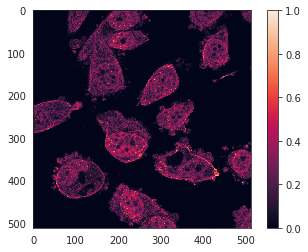

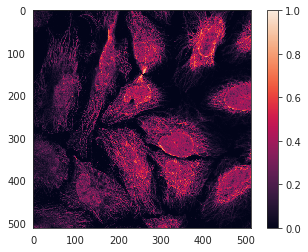

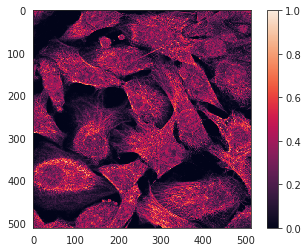

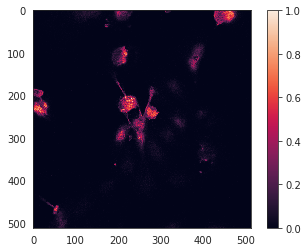

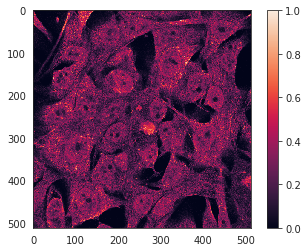

(3, 2030, 815)


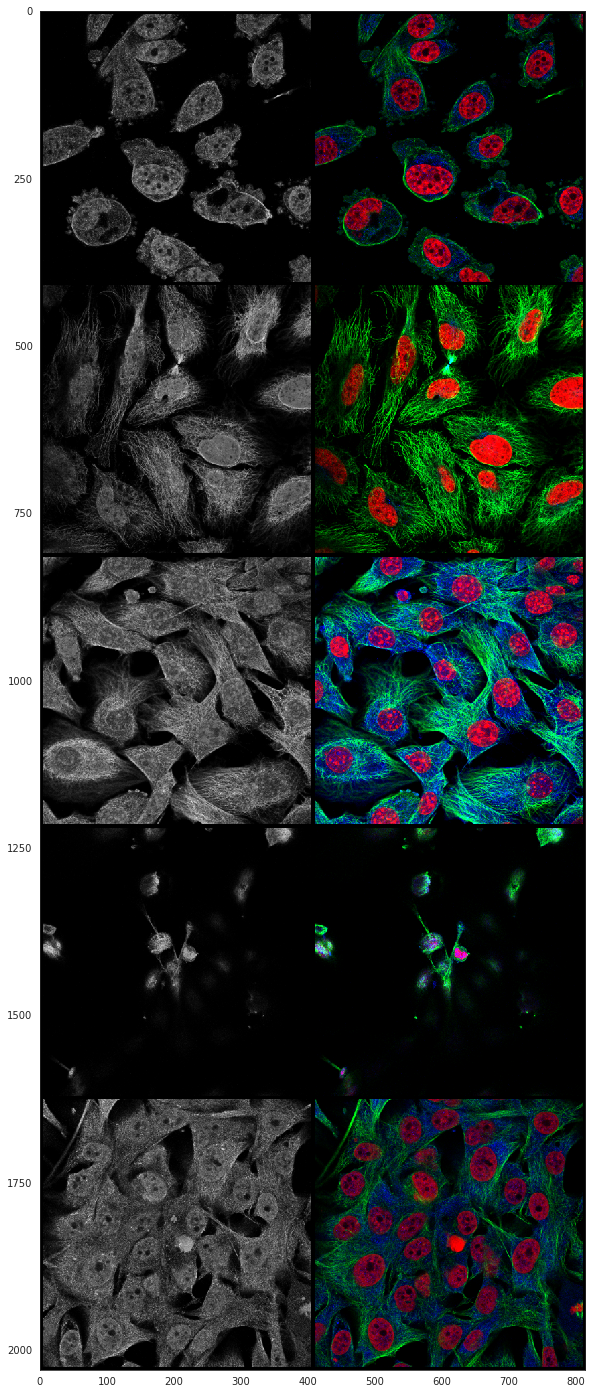

In [8]:
_, v_loader = get_dataloaders_args(
    '../data/hpa/valid', '../data/hpa/valid',
    merged_channels=None, dataset_norm=True)

stacker = ImageStacker(2, 5)
data_iter = iter(v_loader)

for i in range(0, 5):
    val_gray_one, val_gray, val_color = next(data_iter)
    plt.imshow(val_gray_one.squeeze(0).squeeze(0).numpy())
    plt.colorbar()
    plt.show()
    stacker.add_row(val_gray, val_color)

for grid in stacker.grids():
    print(grid.numpy().shape)
    show_tensor(grid, pixel_scale=80)
    #plt.imshow(grid)

In [10]:
train_pix2pix('../data/hpa/train', '../data/hpa/valid', name='kek',
              merged_channels=['red', 'green'], dataset_norm=True,
              niter=10, niter_decay=10, lambda_L1=10)

  0%|          | 0/1553 [00:00<?, ?it/s]

initialize network with normal
initialize network with normal
---------- Networks initialized -------------
[Network G] Total number of parameters : 11.372 M
[Network D] Total number of parameters : 2.766 M
-----------------------------------------------


[1/21] losses: OrderedDict([('G_GAN', 0.46062105894088745), ('G_L1', 0.9228781461715698), ('D_real', 0.2907876670360565), ('D_fake', 0.19787748157978058)]):  16%|█▌        | 250/1553 [01:33<08:47,  2.47it/s] 

saving the latest model (epoch 1, total_iters 5000)


[1/21] losses: OrderedDict([('G_GAN', 0.4678991138935089), ('G_L1', 0.6359677314758301), ('D_real', 0.3478904962539673), ('D_fake', 0.04257410764694214)]):  32%|███▏      | 500/1553 [03:07<06:59,  2.51it/s]   

saving the latest model (epoch 1, total_iters 10000)


[1/21] losses: OrderedDict([('G_GAN', 0.45477497577667236), ('G_L1', 0.7300955057144165), ('D_real', 0.3877524137496948), ('D_fake', 0.043290525674819946)]):  48%|████▊     | 750/1553 [04:41<05:20,  2.51it/s]

saving the latest model (epoch 1, total_iters 15000)


[1/21] losses: OrderedDict([('G_GAN', 0.734025239944458), ('G_L1', 0.6243589520454407), ('D_real', 0.490243136882782), ('D_fake', 0.12294048815965652)]):  64%|██████▍   | 1000/1553 [06:15<03:40,  2.51it/s]   

saving the latest model (epoch 1, total_iters 20000)


[1/21] losses: OrderedDict([('G_GAN', 0.7572970986366272), ('G_L1', 0.6998371481895447), ('D_real', 0.06776514649391174), ('D_fake', 0.02137243188917637)]):  80%|████████  | 1250/1553 [07:49<02:00,  2.51it/s]  

saving the latest model (epoch 1, total_iters 25000)


[1/21] losses: OrderedDict([('G_GAN', 0.8949410319328308), ('G_L1', 0.5595905184745789), ('D_real', 0.06130525469779968), ('D_fake', 0.1545877307653427)]):  97%|█████████▋| 1500/1553 [09:23<00:21,  2.51it/s]   

saving the latest model (epoch 1, total_iters 30000)


[1/21] losses: OrderedDict([('G_GAN', 0.7748798727989197), ('G_L1', 0.5994584560394287), ('D_real', 0.0631771981716156), ('D_fake', 0.025416864082217216)]): 100%|██████████| 1553/1553 [09:42<00:00,  3.02it/s]  
[converting monochrome images to colored images]:   0%|          | 0/20 [00:00<?, ?it/s]

saving the model at the end of epoch 1, iters 31060


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[2/21] losses: OrderedDict([('G_GAN', 0.802172839641571), ('G_L1', 0.6069852113723755), ('D_real', 0.03222304582595825), ('D_fake', 0.2153417021036148)]):  13%|█▎        | 197/1553 [01:14<09:10,  2.46it/s]    

saving the latest model (epoch 2, total_iters 35000)


[2/21] losses: OrderedDict([('G_GAN', 0.9889442324638367), ('G_L1', 0.5488011240959167), ('D_real', 0.033256206661462784), ('D_fake', 0.024411384016275406)]):  29%|██▉       | 447/1553 [02:48<07:28,  2.47it/s]

saving the latest model (epoch 2, total_iters 40000)


[2/21] losses: OrderedDict([('G_GAN', 0.8998764753341675), ('G_L1', 0.6053535342216492), ('D_real', 0.026409611105918884), ('D_fake', 0.02903418429195881)]):  45%|████▍     | 697/1553 [04:22<05:46,  2.47it/s] 

saving the latest model (epoch 2, total_iters 45000)


[2/21] losses: OrderedDict([('G_GAN', 0.9555462598800659), ('G_L1', 0.5377158522605896), ('D_real', 0.07146310061216354), ('D_fake', 0.03074030764400959)]):  61%|██████    | 947/1553 [05:56<04:05,  2.47it/s]  

saving the latest model (epoch 2, total_iters 50000)


[2/21] losses: OrderedDict([('G_GAN', 1.0760576725006104), ('G_L1', 0.5328909158706665), ('D_real', 0.06007751077413559), ('D_fake', 0.08326428383588791)]):  77%|███████▋  | 1197/1553 [07:29<02:24,  2.47it/s]   

saving the latest model (epoch 2, total_iters 55000)


[2/21] losses: OrderedDict([('G_GAN', 0.8226332068443298), ('G_L1', 0.6176915168762207), ('D_real', 0.16826990246772766), ('D_fake', 0.042158905416727066)]):  93%|█████████▎| 1447/1553 [09:03<00:42,  2.48it/s]  

saving the latest model (epoch 2, total_iters 60000)


[2/21] losses: OrderedDict([('G_GAN', 0.6464703679084778), ('G_L1', 0.4453630745410919), ('D_real', 0.1812916249036789), ('D_fake', 0.03129192069172859)]): 100%|██████████| 1553/1553 [09:43<00:00,  3.03it/s]    
[converting monochrome images to colored images]:   0%|          | 0/20 [00:00<?, ?it/s]

saving the model at the end of epoch 2, iters 62120


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[3/21] losses: OrderedDict([('G_GAN', 1.0749447345733643), ('G_L1', 0.519199550151825), ('D_real', 0.062143225222826004), ('D_fake', 0.08429110050201416)]):   9%|▉         | 144/1553 [00:55<09:36,  2.45it/s]   

saving the latest model (epoch 3, total_iters 65000)


[3/21] losses: OrderedDict([('G_GAN', 0.6625826358795166), ('G_L1', 0.5014564394950867), ('D_real', 0.14162865281105042), ('D_fake', 0.051921993494033813)]):  25%|██▌       | 394/1553 [02:28<07:49,  2.47it/s]  

saving the latest model (epoch 3, total_iters 70000)


[3/21] losses: OrderedDict([('G_GAN', 0.9707275629043579), ('G_L1', 0.5910331606864929), ('D_real', 0.020190710201859474), ('D_fake', 0.017352266237139702)]):  41%|████▏     | 644/1553 [04:02<06:01,  2.51it/s] 

saving the latest model (epoch 3, total_iters 75000)


[3/21] losses: OrderedDict([('G_GAN', 1.208536148071289), ('G_L1', 0.5751661658287048), ('D_real', 0.01568910852074623), ('D_fake', 0.10974068939685822)]):  58%|█████▊    | 894/1553 [05:36<04:22,  2.51it/s]    

saving the latest model (epoch 3, total_iters 80000)


[3/21] losses: OrderedDict([('G_GAN', 0.9490705728530884), ('G_L1', 0.6402224898338318), ('D_real', 0.027759769931435585), ('D_fake', 0.029490094631910324)]):  74%|███████▎  | 1144/1553 [07:10<02:42,  2.51it/s] 

saving the latest model (epoch 3, total_iters 85000)


[3/21] losses: OrderedDict([('G_GAN', 0.8393546342849731), ('G_L1', 0.5494018793106079), ('D_real', 0.03131140395998955), ('D_fake', 0.02912394143640995)]):  90%|████████▉ | 1394/1553 [08:44<01:03,  2.51it/s]   

saving the latest model (epoch 3, total_iters 90000)


[3/21] losses: OrderedDict([('G_GAN', 0.618861973285675), ('G_L1', 0.5559620261192322), ('D_real', 0.3334939479827881), ('D_fake', 0.03741902858018875)]): 100%|██████████| 1553/1553 [09:43<00:00,  3.03it/s]     
[converting monochrome images to colored images]:   0%|          | 0/20 [00:00<?, ?it/s]

saving the model at the end of epoch 3, iters 93180


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[4/21] losses: OrderedDict([('G_GAN', 1.1084909439086914), ('G_L1', 0.5461061596870422), ('D_real', 0.017702504992485046), ('D_fake', 0.026889389380812645)]):   6%|▌         | 91/1553 [00:35<09:58,  2.44it/s] 

saving the latest model (epoch 4, total_iters 95000)


[4/21] losses: OrderedDict([('G_GAN', 0.8341737389564514), ('G_L1', 0.6236476898193359), ('D_real', 0.026761000975966454), ('D_fake', 0.021140702068805695)]):  22%|██▏       | 341/1553 [02:08<08:01,  2.52it/s] 

saving the latest model (epoch 4, total_iters 100000)


[4/21] losses: OrderedDict([('G_GAN', 1.042543649673462), ('G_L1', 0.6662026047706604), ('D_real', 0.022467926144599915), ('D_fake', 0.009951886720955372)]):  38%|███▊      | 591/1553 [03:42<06:23,  2.51it/s]  

saving the latest model (epoch 4, total_iters 105000)


[4/21] losses: OrderedDict([('G_GAN', 0.56229567527771), ('G_L1', 0.4703614413738251), ('D_real', 0.23615829646587372), ('D_fake', 0.01622924394905567)]):  54%|█████▍    | 841/1553 [05:16<04:43,  2.51it/s]     

saving the latest model (epoch 4, total_iters 110000)


[4/21] losses: OrderedDict([('G_GAN', 0.9948295950889587), ('G_L1', 0.5900731086730957), ('D_real', 0.048224709928035736), ('D_fake', 0.00988220889121294)]):  70%|███████   | 1091/1553 [06:50<03:04,  2.51it/s]  

saving the latest model (epoch 4, total_iters 115000)


[4/21] losses: OrderedDict([('G_GAN', 0.7925938963890076), ('G_L1', 0.5772036910057068), ('D_real', 0.05103909224271774), ('D_fake', 0.02698228880763054)]):  86%|████████▋ | 1341/1553 [08:24<01:24,  2.51it/s]   

saving the latest model (epoch 4, total_iters 120000)


[4/21] losses: OrderedDict([('G_GAN', 0.9932527542114258), ('G_L1', 0.5061776638031006), ('D_real', 0.025805603712797165), ('D_fake', 0.023241687566041946)]): 100%|██████████| 1553/1553 [09:44<00:00,  3.02it/s] 
[converting monochrome images to colored images]:   0%|          | 0/20 [00:00<?, ?it/s]

saving the model at the end of epoch 4, iters 124240


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[5/21] losses: OrderedDict([('G_GAN', 0.9089397192001343), ('G_L1', 0.5746873617172241), ('D_real', 0.040505703538656235), ('D_fake', 0.019809452816843987)]):   2%|▏         | 38/1553 [00:15<10:20,  2.44it/s] 

saving the latest model (epoch 5, total_iters 125000)


[5/21] losses: OrderedDict([('G_GAN', 0.9239306449890137), ('G_L1', 0.5305129289627075), ('D_real', 0.05089636147022247), ('D_fake', 0.024713406339287758)]):  19%|█▊        | 288/1553 [01:49<08:22,  2.52it/s]  

saving the latest model (epoch 5, total_iters 130000)


[5/21] losses: OrderedDict([('G_GAN', 0.8323606252670288), ('G_L1', 0.4870724380016327), ('D_real', 0.0335216261446476), ('D_fake', 0.010630092583596706)]):  35%|███▍      | 538/1553 [03:22<06:43,  2.51it/s]   

saving the latest model (epoch 5, total_iters 135000)


[5/21] losses: OrderedDict([('G_GAN', 1.0812584161758423), ('G_L1', 0.44936880469322205), ('D_real', 0.012879341840744019), ('D_fake', 0.028011314570903778)]):  51%|█████     | 788/1553 [04:56<05:03,  2.52it/s]

saving the latest model (epoch 5, total_iters 140000)


[5/21] losses: OrderedDict([('G_GAN', 1.0954984426498413), ('G_L1', 0.4739135503768921), ('D_real', 0.033095818012952805), ('D_fake', 0.017074698582291603)]):  67%|██████▋   | 1038/1553 [06:30<03:24,  2.52it/s]

saving the latest model (epoch 5, total_iters 145000)


[5/21] losses: OrderedDict([('G_GAN', 1.0099958181381226), ('G_L1', 0.38223668932914734), ('D_real', 0.011916997842490673), ('D_fake', 0.016273261979222298)]):  83%|████████▎ | 1288/1553 [08:04<01:45,  2.51it/s] 

saving the latest model (epoch 5, total_iters 150000)


[5/21] losses: OrderedDict([('G_GAN', 1.08060884475708), ('G_L1', 0.40528231859207153), ('D_real', 0.005972895305603743), ('D_fake', 0.04188619554042816)]):  99%|█████████▉| 1538/1553 [09:37<00:05,  2.52it/s]   

saving the latest model (epoch 5, total_iters 155000)


[5/21] losses: OrderedDict([('G_GAN', 1.065361499786377), ('G_L1', 0.48264098167419434), ('D_real', 0.007129522040486336), ('D_fake', 0.015672963112592697)]): 100%|██████████| 1553/1553 [09:43<00:00,  3.03it/s] 
[converting monochrome images to colored images]:   0%|          | 0/20 [00:00<?, ?it/s]

saving the model at the end of epoch 5, iters 155300


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[6/21] losses: OrderedDict([('G_GAN', 0.9038020968437195), ('G_L1', 0.4896002411842346), ('D_real', 0.040003351867198944), ('D_fake', 0.007488996721804142)]):  15%|█▌        | 235/1553 [01:29<08:59,  2.45it/s] 

saving the latest model (epoch 6, total_iters 160000)


[6/21] losses: OrderedDict([('G_GAN', 1.0488903522491455), ('G_L1', 0.48463302850723267), ('D_real', 0.15664972364902496), ('D_fake', 0.1407320201396942)]):  31%|███       | 485/1553 [03:02<07:04,  2.52it/s]    

saving the latest model (epoch 6, total_iters 165000)


[6/21] losses: OrderedDict([('G_GAN', 0.969226062297821), ('G_L1', 0.5527235269546509), ('D_real', 0.02635347656905651), ('D_fake', 0.01736912503838539)]):  47%|████▋     | 735/1553 [04:36<05:25,  2.51it/s]     

saving the latest model (epoch 6, total_iters 170000)


[6/21] losses: OrderedDict([('G_GAN', 1.0282131433486938), ('G_L1', 0.4252208471298218), ('D_real', 0.043018240481615067), ('D_fake', 0.06646724790334702)]):  63%|██████▎   | 985/1553 [06:10<03:45,  2.51it/s]   

saving the latest model (epoch 6, total_iters 175000)


[6/21] losses: OrderedDict([('G_GAN', 0.30531108379364014), ('G_L1', 0.4999372065067291), ('D_real', 0.5497391223907471), ('D_fake', 0.029924064874649048)]):  80%|███████▉  | 1235/1553 [07:44<02:06,  2.52it/s]   

saving the latest model (epoch 6, total_iters 180000)


[6/21] losses: OrderedDict([('G_GAN', 0.8525036573410034), ('G_L1', 0.6219499111175537), ('D_real', 0.08611179888248444), ('D_fake', 0.029784588143229485)]):  96%|█████████▌| 1485/1553 [09:17<00:27,  2.51it/s]   

saving the latest model (epoch 6, total_iters 185000)


[6/21] losses: OrderedDict([('G_GAN', 0.9740093946456909), ('G_L1', 0.3741973638534546), ('D_real', 0.033610254526138306), ('D_fake', 0.13765288889408112)]): 100%|██████████| 1553/1553 [09:43<00:00,  3.03it/s]   
[converting monochrome images to colored images]:   0%|          | 0/20 [00:00<?, ?it/s]

saving the model at the end of epoch 6, iters 186360


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[7/21] losses: OrderedDict([('G_GAN', 0.457737535238266), ('G_L1', 0.5185121297836304), ('D_real', 0.19067832827568054), ('D_fake', 0.14205588400363922)]):  12%|█▏        | 182/1553 [01:09<09:18,  2.45it/s]   

saving the latest model (epoch 7, total_iters 190000)


[7/21] losses: OrderedDict([('G_GAN', 0.8300153613090515), ('G_L1', 0.5064951181411743), ('D_real', 0.034927673637866974), ('D_fake', 0.14148566126823425)]):  28%|██▊       | 432/1553 [02:42<07:26,  2.51it/s]  

saving the latest model (epoch 7, total_iters 195000)


[7/21] losses: OrderedDict([('G_GAN', 0.5473988652229309), ('G_L1', 0.44521719217300415), ('D_real', 0.1458669751882553), ('D_fake', 0.07764468342065811)]):  44%|████▍     | 682/1553 [04:16<05:46,  2.51it/s]   

saving the latest model (epoch 7, total_iters 200000)


[7/21] losses: OrderedDict([('G_GAN', 0.8867383599281311), ('G_L1', 0.3478175401687622), ('D_real', 0.01662164181470871), ('D_fake', 0.04897022247314453)]):  60%|██████    | 932/1553 [05:50<04:06,  2.52it/s]   

saving the latest model (epoch 7, total_iters 205000)


[7/21] losses: OrderedDict([('G_GAN', 0.8961783647537231), ('G_L1', 0.4467717111110687), ('D_real', 0.011182310990989208), ('D_fake', 0.04700541868805885)]):  76%|███████▌  | 1182/1553 [07:24<02:27,  2.52it/s]  

saving the latest model (epoch 7, total_iters 210000)


[7/21] losses: OrderedDict([('G_GAN', 0.9672743082046509), ('G_L1', 0.36832913756370544), ('D_real', 0.059452056884765625), ('D_fake', 0.11641649901866913)]):  92%|█████████▏| 1432/1553 [08:58<00:48,  2.52it/s] 

saving the latest model (epoch 7, total_iters 215000)


[7/21] losses: OrderedDict([('G_GAN', 0.2476634681224823), ('G_L1', 0.48099470138549805), ('D_real', 0.21658030152320862), ('D_fake', 0.2723676562309265)]): 100%|██████████| 1553/1553 [09:43<00:00,  3.03it/s]   
[converting monochrome images to colored images]:   0%|          | 0/20 [00:00<?, ?it/s]

saving the model at the end of epoch 7, iters 217420


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[8/21] losses: OrderedDict([('G_GAN', 0.9532375931739807), ('G_L1', 0.45073094964027405), ('D_real', 0.04307075962424278), ('D_fake', 0.01949577033519745)]):   8%|▊         | 129/1553 [00:49<09:41,  2.45it/s]  

saving the latest model (epoch 8, total_iters 220000)


[8/21] losses: OrderedDict([('G_GAN', 0.8864991664886475), ('G_L1', 0.5079420804977417), ('D_real', 0.050146665424108505), ('D_fake', 0.022767914459109306)]):  24%|██▍       | 379/1553 [02:23<07:47,  2.51it/s]  

saving the latest model (epoch 8, total_iters 225000)


[8/21] losses: OrderedDict([('G_GAN', 1.1684982776641846), ('G_L1', 0.4713064730167389), ('D_real', 0.18230319023132324), ('D_fake', 0.10393591225147247)]):  41%|████      | 629/1553 [03:56<06:07,  2.52it/s]   

saving the latest model (epoch 8, total_iters 230000)


[8/21] losses: OrderedDict([('G_GAN', 0.9664778709411621), ('G_L1', 0.653145968914032), ('D_real', 0.024846062064170837), ('D_fake', 0.03992052748799324)]):  57%|█████▋    | 879/1553 [05:30<04:27,  2.52it/s]   

saving the latest model (epoch 8, total_iters 235000)


[8/21] losses: OrderedDict([('G_GAN', 0.9634294509887695), ('G_L1', 0.46910154819488525), ('D_real', 0.06614511460065842), ('D_fake', 0.02884831465780735)]):  73%|███████▎  | 1129/1553 [07:04<02:48,  2.52it/s]    

saving the latest model (epoch 8, total_iters 240000)


[8/21] losses: OrderedDict([('G_GAN', 0.9996131658554077), ('G_L1', 0.4578899145126343), ('D_real', 0.01177921798080206), ('D_fake', 0.0486748106777668)]):  89%|████████▉ | 1379/1553 [08:38<01:09,  2.49it/s]     

saving the latest model (epoch 8, total_iters 245000)


[8/21] losses: OrderedDict([('G_GAN', 0.9962506294250488), ('G_L1', 0.5087587833404541), ('D_real', 0.013427972793579102), ('D_fake', 0.0184235367923975)]): 100%|██████████| 1553/1553 [09:43<00:00,  3.03it/s]    
[converting monochrome images to colored images]:   0%|          | 0/20 [00:00<?, ?it/s]

saving the model at the end of epoch 8, iters 248480


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[9/21] losses: OrderedDict([('G_GAN', 0.8918126225471497), ('G_L1', 0.46637147665023804), ('D_real', 0.008283782750368118), ('D_fake', 0.007009545341134071)]):   5%|▍         | 76/1553 [00:29<10:01,  2.45it/s] 

saving the latest model (epoch 9, total_iters 250000)


[9/21] losses: OrderedDict([('G_GAN', 1.003943681716919), ('G_L1', 0.4087883234024048), ('D_real', 0.0026943334378302097), ('D_fake', 0.003082116600126028)]):  21%|██        | 326/1553 [02:03<08:07,  2.52it/s]  

saving the latest model (epoch 9, total_iters 255000)


[9/21] losses: OrderedDict([('G_GAN', 0.9514551162719727), ('G_L1', 0.37113335728645325), ('D_real', 0.014978046528995037), ('D_fake', 0.01029985025525093)]):  37%|███▋      | 576/1553 [03:36<06:28,  2.51it/s]   

saving the latest model (epoch 9, total_iters 260000)


[9/21] losses: OrderedDict([('G_GAN', 0.9503652453422546), ('G_L1', 0.4250467121601105), ('D_real', 0.03853693976998329), ('D_fake', 0.005041539669036865)]):  53%|█████▎    | 826/1553 [05:10<04:48,  2.52it/s]   

saving the latest model (epoch 9, total_iters 265000)


[9/21] losses: OrderedDict([('G_GAN', 1.3317153453826904), ('G_L1', 0.4118513762950897), ('D_real', 0.011176780797541142), ('D_fake', 0.12342491000890732)]):  69%|██████▉   | 1076/1553 [06:44<03:09,  2.51it/s]   

saving the latest model (epoch 9, total_iters 270000)


[9/21] losses: OrderedDict([('G_GAN', 1.0115338563919067), ('G_L1', 0.40311700105667114), ('D_real', 0.0022047983948141336), ('D_fake', 0.002605526940897107)]):  85%|████████▌ | 1326/1553 [08:18<01:30,  2.52it/s] 

saving the latest model (epoch 9, total_iters 275000)


[9/21] losses: OrderedDict([('G_GAN', 1.0759574174880981), ('G_L1', 0.38177990913391113), ('D_real', 0.2120400220155716), ('D_fake', 0.19253672659397125)]): 100%|██████████| 1553/1553 [09:43<00:00,  3.03it/s]     
[converting monochrome images to colored images]:   0%|          | 0/20 [00:00<?, ?it/s]

saving the model at the end of epoch 9, iters 279540


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[10/21] losses: OrderedDict([('G_GAN', 1.0907803773880005), ('G_L1', 0.4459744393825531), ('D_real', 0.018299534916877747), ('D_fake', 0.007045348174870014)]):   1%|▏         | 23/1553 [00:09<10:24,  2.45it/s] 

saving the latest model (epoch 10, total_iters 280000)


[10/21] losses: OrderedDict([('G_GAN', 0.9036325216293335), ('G_L1', 0.4883852005004883), ('D_real', 0.006211997475475073), ('D_fake', 0.0075322771444916725)]):  18%|█▊        | 273/1553 [01:43<08:31,  2.50it/s]  

saving the latest model (epoch 10, total_iters 285000)


[10/21] losses: OrderedDict([('G_GAN', 0.944598376750946), ('G_L1', 0.4083954989910126), ('D_real', 0.021552331745624542), ('D_fake', 0.011801173910498619)]):  34%|███▎      | 523/1553 [03:17<06:49,  2.52it/s]   

saving the latest model (epoch 10, total_iters 290000)


[10/21] losses: OrderedDict([('G_GAN', 1.0425864458084106), ('G_L1', 0.4593217074871063), ('D_real', 0.009583301842212677), ('D_fake', 0.018761450424790382)]):  50%|████▉     | 773/1553 [04:50<05:10,  2.51it/s]   

saving the latest model (epoch 10, total_iters 295000)


[10/21] losses: OrderedDict([('G_GAN', 0.9447980523109436), ('G_L1', 0.40174323320388794), ('D_real', 0.010283133015036583), ('D_fake', 0.012192589230835438)]):  63%|██████▎   | 979/1553 [06:08<03:34,  2.67it/s]  Traceback (most recent call last):
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/multiprocessing/queues.

KeyboardInterrupt: 

In [8]:
train_pix2pix('../data/hpa/train', '../data/hpa/valid', name='kek_unet128',
              netG='unet_128', crop_size=128,
              merged_channels=['red', 'green'], dataset_norm=True,
              niter=10, niter_decay=10, lambda_L1=20)

  0%|          | 0/1553 [00:00<?, ?it/s]

initialize network with normal
initialize network with normal
---------- Networks initialized -------------
[Network G] Total number of parameters : 41.824 M
[Network D] Total number of parameters : 2.766 M
-----------------------------------------------


[1/21] losses: OrderedDict([('G_GAN', 0.4017127454280853), ('G_L1', 1.5236653089523315), ('D_real', 0.23755690455436707), ('D_fake', 0.17806437611579895)]):  16%|█▌        | 249/1553 [00:25<02:06, 10.31it/s] 

saving the latest model (epoch 1, total_iters 5000)


[1/21] losses: OrderedDict([('G_GAN', 0.6661233901977539), ('G_L1', 1.5639348030090332), ('D_real', 0.36807572841644287), ('D_fake', 0.40461981296539307)]):  32%|███▏      | 499/1553 [00:49<01:42, 10.26it/s] 

saving the latest model (epoch 1, total_iters 10000)


[1/21] losses: OrderedDict([('G_GAN', 0.3601321578025818), ('G_L1', 1.1663129329681396), ('D_real', 0.2305040806531906), ('D_fake', 0.17179568111896515)]):  48%|████▊     | 749/1553 [01:14<01:18, 10.23it/s]  

saving the latest model (epoch 1, total_iters 15000)


[1/21] losses: OrderedDict([('G_GAN', 0.4072567820549011), ('G_L1', 1.1757017374038696), ('D_real', 0.23923714458942413), ('D_fake', 0.16652493178844452)]):  64%|██████▍   | 999/1553 [01:39<00:53, 10.26it/s] 

saving the latest model (epoch 1, total_iters 20000)


[1/21] losses: OrderedDict([('G_GAN', 0.4469965100288391), ('G_L1', 1.1961610317230225), ('D_real', 0.2253166288137436), ('D_fake', 0.11055419594049454)]):  80%|████████  | 1249/1553 [02:04<00:29, 10.21it/s]   

saving the latest model (epoch 1, total_iters 25000)


[1/21] losses: OrderedDict([('G_GAN', 0.3867688775062561), ('G_L1', 1.3718750476837158), ('D_real', 0.2795305550098419), ('D_fake', 0.17732079327106476)]):  97%|█████████▋| 1499/1553 [02:28<00:05, 10.21it/s]  

saving the latest model (epoch 1, total_iters 30000)


[1/21] losses: OrderedDict([('G_GAN', 0.6186659336090088), ('G_L1', 1.3529103994369507), ('D_real', 0.17640507221221924), ('D_fake', 0.3710409104824066)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.90it/s]  


saving the model at the end of epoch 1, iters 31060


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[2/21] losses: OrderedDict([('G_GAN', 0.8539856672286987), ('G_L1', 1.1691268682479858), ('D_real', 0.11811122298240662), ('D_fake', 0.40864211320877075)]):  13%|█▎        | 195/1553 [00:20<02:12, 10.26it/s] 

saving the latest model (epoch 2, total_iters 35000)


[2/21] losses: OrderedDict([('G_GAN', 0.4789787530899048), ('G_L1', 1.1471296548843384), ('D_real', 0.3260461688041687), ('D_fake', 0.18293949961662292)]):  29%|██▊       | 445/1553 [00:45<01:48, 10.24it/s]   

saving the latest model (epoch 2, total_iters 40000)


[2/21] losses: OrderedDict([('G_GAN', 0.40613463521003723), ('G_L1', 1.1287872791290283), ('D_real', 0.3769408166408539), ('D_fake', 0.08983631432056427)]):  45%|████▍     | 695/1553 [01:09<01:23, 10.22it/s]  

saving the latest model (epoch 2, total_iters 45000)


[2/21] losses: OrderedDict([('G_GAN', 1.0493879318237305), ('G_L1', 1.3099814653396606), ('D_real', 0.061535388231277466), ('D_fake', 0.4149056375026703)]):  61%|██████    | 945/1553 [01:34<00:59, 10.20it/s]  

saving the latest model (epoch 2, total_iters 50000)


[2/21] losses: OrderedDict([('G_GAN', 0.6798111200332642), ('G_L1', 1.0880411863327026), ('D_real', 0.21970686316490173), ('D_fake', 0.18403126299381256)]):  77%|███████▋  | 1196/1553 [01:59<00:34, 10.21it/s]  

saving the latest model (epoch 2, total_iters 55000)


[2/21] losses: OrderedDict([('G_GAN', 0.771481454372406), ('G_L1', 1.252694010734558), ('D_real', 0.15213795006275177), ('D_fake', 0.19890494644641876)]):  93%|█████████▎| 1446/1553 [02:24<00:10, 10.21it/s]   

saving the latest model (epoch 2, total_iters 60000)


[2/21] losses: OrderedDict([('G_GAN', 0.8205057382583618), ('G_L1', 0.9197745323181152), ('D_real', 0.0519503690302372), ('D_fake', 0.4186461567878723)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.03it/s]   


saving the model at the end of epoch 2, iters 62120


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[3/21] losses: OrderedDict([('G_GAN', 0.3197768032550812), ('G_L1', 1.0653210878372192), ('D_real', 0.48460689187049866), ('D_fake', 0.04949166253209114)]):   9%|▉         | 143/1553 [00:15<02:17, 10.26it/s]  

saving the latest model (epoch 3, total_iters 65000)


[3/21] losses: OrderedDict([('G_GAN', 0.7393892407417297), ('G_L1', 1.2153078317642212), ('D_real', 0.08678234368562698), ('D_fake', 0.1636287420988083)]):  25%|██▌       | 393/1553 [00:39<01:53, 10.24it/s]   

saving the latest model (epoch 3, total_iters 70000)


[3/21] losses: OrderedDict([('G_GAN', 0.5469260811805725), ('G_L1', 1.0106645822525024), ('D_real', 0.2230653464794159), ('D_fake', 0.08146287500858307)]):  41%|████▏     | 643/1553 [01:04<01:28, 10.23it/s]   

saving the latest model (epoch 3, total_iters 75000)


[3/21] losses: OrderedDict([('G_GAN', 0.7712854146957397), ('G_L1', 1.191516399383545), ('D_real', 0.10968536138534546), ('D_fake', 0.1505614072084427)]):  58%|█████▊    | 893/1553 [01:29<01:04, 10.23it/s]    

saving the latest model (epoch 3, total_iters 80000)


[3/21] losses: OrderedDict([('G_GAN', 0.3415295481681824), ('G_L1', 1.163295865058899), ('D_real', 0.4272017776966095), ('D_fake', 0.0894375592470169)]):  74%|███████▎  | 1143/1553 [01:53<00:40, 10.21it/s]    

saving the latest model (epoch 3, total_iters 85000)


[3/21] losses: OrderedDict([('G_GAN', 1.266485571861267), ('G_L1', 1.0455750226974487), ('D_real', 0.11055394262075424), ('D_fake', 0.37647542357444763)]):  90%|████████▉ | 1393/1553 [02:18<00:15, 10.18it/s]  

saving the latest model (epoch 3, total_iters 90000)


[3/21] losses: OrderedDict([('G_GAN', 0.6172841787338257), ('G_L1', 1.0489184856414795), ('D_real', 0.15964403748512268), ('D_fake', 0.05739102512598038)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.05it/s] 


saving the model at the end of epoch 3, iters 93180


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[4/21] losses: OrderedDict([('G_GAN', 0.3584139943122864), ('G_L1', 1.2156777381896973), ('D_real', 0.5484558939933777), ('D_fake', 0.019018689170479774)]):   6%|▌         | 89/1553 [00:09<02:23, 10.23it/s]  

saving the latest model (epoch 4, total_iters 95000)


[4/21] losses: OrderedDict([('G_GAN', 1.4197566509246826), ('G_L1', 1.4002435207366943), ('D_real', 0.10068488121032715), ('D_fake', 0.4120994508266449)]):  22%|██▏       | 339/1553 [00:34<01:58, 10.25it/s]  

saving the latest model (epoch 4, total_iters 100000)


[4/21] losses: OrderedDict([('G_GAN', 0.7045270800590515), ('G_L1', 1.315487027168274), ('D_real', 0.18175652623176575), ('D_fake', 0.057347603142261505)]):  38%|███▊      | 589/1553 [00:59<01:34, 10.26it/s] 

saving the latest model (epoch 4, total_iters 105000)


[4/21] losses: OrderedDict([('G_GAN', 1.0988855361938477), ('G_L1', 1.226944923400879), ('D_real', 0.08102121204137802), ('D_fake', 0.16591955721378326)]):  54%|█████▍    | 839/1553 [01:24<01:09, 10.25it/s]   

saving the latest model (epoch 4, total_iters 110000)


[4/21] losses: OrderedDict([('G_GAN', 1.3255884647369385), ('G_L1', 1.0888950824737549), ('D_real', 0.06495604664087296), ('D_fake', 0.3788328170776367)]):  70%|███████   | 1089/1553 [01:48<00:45, 10.24it/s]  

saving the latest model (epoch 4, total_iters 115000)


[4/21] losses: OrderedDict([('G_GAN', 1.0030593872070312), ('G_L1', 1.1049456596374512), ('D_real', 0.10567400604486465), ('D_fake', 0.2586091160774231)]):  86%|████████▌ | 1339/1553 [02:13<00:20, 10.26it/s]   

saving the latest model (epoch 4, total_iters 120000)


[4/21] losses: OrderedDict([('G_GAN', 0.9546738266944885), ('G_L1', 1.2409026622772217), ('D_real', 0.047624822705984116), ('D_fake', 0.10555294901132584)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.89it/s] 


saving the model at the end of epoch 4, iters 124240


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[5/21] losses: OrderedDict([('G_GAN', 0.7231619358062744), ('G_L1', 1.044598937034607), ('D_real', 0.12396912276744843), ('D_fake', 0.11428268998861313)]):   2%|▏         | 37/1553 [00:04<02:29, 10.16it/s] 

saving the latest model (epoch 5, total_iters 125000)


[5/21] losses: OrderedDict([('G_GAN', 0.42379286885261536), ('G_L1', 1.1815917491912842), ('D_real', 0.4654025733470917), ('D_fake', 0.03223002329468727)]):  18%|█▊        | 287/1553 [00:29<02:04, 10.20it/s]  

saving the latest model (epoch 5, total_iters 130000)


[5/21] losses: OrderedDict([('G_GAN', 1.1794238090515137), ('G_L1', 1.502840518951416), ('D_real', 0.03702457994222641), ('D_fake', 0.05889873951673508)]):  35%|███▍      | 536/1553 [00:54<01:39, 10.24it/s]  

saving the latest model (epoch 5, total_iters 135000)


[5/21] losses: OrderedDict([('G_GAN', 1.0234194993972778), ('G_L1', 1.2682549953460693), ('D_real', 0.09500959515571594), ('D_fake', 0.028498157858848572)]):  51%|█████     | 786/1553 [01:18<01:14, 10.27it/s] 

saving the latest model (epoch 5, total_iters 140000)


[5/21] losses: OrderedDict([('G_GAN', 1.2334175109863281), ('G_L1', 0.9903562068939209), ('D_real', 0.037077996879816055), ('D_fake', 0.12687645852565765)]):  67%|██████▋   | 1036/1553 [01:43<00:50, 10.23it/s] 

saving the latest model (epoch 5, total_iters 145000)


[5/21] losses: OrderedDict([('G_GAN', 0.6743737459182739), ('G_L1', 1.35996675491333), ('D_real', 0.12686678767204285), ('D_fake', 0.03740748018026352)]):  83%|████████▎ | 1286/1553 [02:08<00:26, 10.27it/s]    

saving the latest model (epoch 5, total_iters 150000)


[5/21] losses: OrderedDict([('G_GAN', 0.6476982235908508), ('G_L1', 1.1287083625793457), ('D_real', 0.3800404369831085), ('D_fake', 0.08919887989759445)]):  99%|█████████▉| 1536/1553 [02:32<00:01, 10.24it/s]   

saving the latest model (epoch 5, total_iters 155000)


[5/21] losses: OrderedDict([('G_GAN', 1.177735686302185), ('G_L1', 1.2511814832687378), ('D_real', 0.03130807727575302), ('D_fake', 0.09868260473012924)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.04it/s]  


saving the model at the end of epoch 5, iters 155300


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[6/21] losses: OrderedDict([('G_GAN', 1.166455864906311), ('G_L1', 1.1664299964904785), ('D_real', 0.0535850003361702), ('D_fake', 0.10788828134536743)]):  15%|█▌        | 233/1553 [00:23<02:08, 10.26it/s]    

saving the latest model (epoch 6, total_iters 160000)


[6/21] losses: OrderedDict([('G_GAN', 0.9965530037879944), ('G_L1', 1.0611515045166016), ('D_real', 0.027712153270840645), ('D_fake', 0.017422715201973915)]):  31%|███       | 483/1553 [00:48<01:44, 10.26it/s]

saving the latest model (epoch 6, total_iters 165000)


[6/21] losses: OrderedDict([('G_GAN', 0.8023823499679565), ('G_L1', 0.9907910227775574), ('D_real', 0.09563029557466507), ('D_fake', 0.03254140540957451)]):  47%|████▋     | 733/1553 [01:13<01:20, 10.23it/s]  

saving the latest model (epoch 6, total_iters 170000)


[6/21] losses: OrderedDict([('G_GAN', 0.6530404090881348), ('G_L1', 0.9191543459892273), ('D_real', 0.08198750764131546), ('D_fake', 0.02332816645503044)]):  63%|██████▎   | 983/1553 [01:38<00:55, 10.26it/s]  

saving the latest model (epoch 6, total_iters 175000)


[6/21] losses: OrderedDict([('G_GAN', 1.0849767923355103), ('G_L1', 1.1998364925384521), ('D_real', 0.09202400594949722), ('D_fake', 0.0633169412612915)]):  79%|███████▉  | 1233/1553 [02:02<00:31, 10.26it/s]   

saving the latest model (epoch 6, total_iters 180000)


[6/21] losses: OrderedDict([('G_GAN', 0.8989171981811523), ('G_L1', 1.1292085647583008), ('D_real', 0.05794690549373627), ('D_fake', 0.023902205750346184)]):  95%|█████████▌| 1483/1553 [02:27<00:06, 10.22it/s] 

saving the latest model (epoch 6, total_iters 185000)


[6/21] losses: OrderedDict([('G_GAN', 0.8151610493659973), ('G_L1', 0.9956833720207214), ('D_real', 0.0420285128057003), ('D_fake', 0.03132060915231705)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.88it/s]   


saving the model at the end of epoch 6, iters 186360


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[7/21] losses: OrderedDict([('G_GAN', 1.0811529159545898), ('G_L1', 1.0349150896072388), ('D_real', 0.06924227625131607), ('D_fake', 0.03681453689932823)]):  12%|█▏        | 181/1553 [00:18<02:13, 10.25it/s]  

saving the latest model (epoch 7, total_iters 190000)


[7/21] losses: OrderedDict([('G_GAN', 1.2160588502883911), ('G_L1', 1.1329190731048584), ('D_real', 0.04170496389269829), ('D_fake', 0.1542292684316635)]):  28%|██▊       | 431/1553 [00:43<01:49, 10.25it/s]   

saving the latest model (epoch 7, total_iters 195000)


[7/21] losses: OrderedDict([('G_GAN', 0.7390057444572449), ('G_L1', 0.990924596786499), ('D_real', 0.17864717543125153), ('D_fake', 0.036130718886852264)]):  44%|████▍     | 681/1553 [01:08<01:24, 10.29it/s]  

saving the latest model (epoch 7, total_iters 200000)


[7/21] losses: OrderedDict([('G_GAN', 1.0793836116790771), ('G_L1', 1.672009825706482), ('D_real', 0.05678115785121918), ('D_fake', 0.074453204870224)]):  60%|█████▉    | 931/1553 [01:32<01:00, 10.24it/s]     

saving the latest model (epoch 7, total_iters 205000)


[7/21] losses: OrderedDict([('G_GAN', 0.8289300203323364), ('G_L1', 1.2025333642959595), ('D_real', 0.10646438598632812), ('D_fake', 0.09549303352832794)]):  76%|███████▌  | 1181/1553 [01:57<00:36, 10.19it/s]  

saving the latest model (epoch 7, total_iters 210000)


[7/21] losses: OrderedDict([('G_GAN', 0.8941737413406372), ('G_L1', 1.1107174158096313), ('D_real', 0.03538016974925995), ('D_fake', 0.03361591324210167)]):  92%|█████████▏| 1431/1553 [02:22<00:11, 10.24it/s]  

saving the latest model (epoch 7, total_iters 215000)


[7/21] losses: OrderedDict([('G_GAN', 1.045639991760254), ('G_L1', 1.0497914552688599), ('D_real', 0.02244667336344719), ('D_fake', 0.06584922969341278)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.06it/s]   


saving the model at the end of epoch 7, iters 217420


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[8/21] losses: OrderedDict([('G_GAN', 1.0975919961929321), ('G_L1', 1.1484943628311157), ('D_real', 0.05197614058852196), ('D_fake', 0.05545163154602051)]):   8%|▊         | 127/1553 [00:13<02:19, 10.26it/s]  

saving the latest model (epoch 8, total_iters 220000)


[8/21] losses: OrderedDict([('G_GAN', 0.7433958053588867), ('G_L1', 1.1958379745483398), ('D_real', 0.1689937263727188), ('D_fake', 0.03127781301736832)]):  24%|██▍       | 377/1553 [00:38<01:54, 10.23it/s]   

saving the latest model (epoch 8, total_iters 225000)


[8/21] losses: OrderedDict([('G_GAN', 0.8634842038154602), ('G_L1', 0.9238506555557251), ('D_real', 0.07077325880527496), ('D_fake', 0.0575745552778244)]):  40%|████      | 627/1553 [01:02<01:30, 10.24it/s]   

saving the latest model (epoch 8, total_iters 230000)


[8/21] losses: OrderedDict([('G_GAN', 0.9173969030380249), ('G_L1', 0.9113090634346008), ('D_real', 0.045465972274541855), ('D_fake', 0.022607823833823204)]):  56%|█████▋    | 877/1553 [01:27<01:06, 10.21it/s]

saving the latest model (epoch 8, total_iters 235000)


[8/21] losses: OrderedDict([('G_GAN', 0.960872232913971), ('G_L1', 1.0086675882339478), ('D_real', 0.2039438784122467), ('D_fake', 0.033233433961868286)]):  73%|███████▎  | 1127/1553 [01:52<00:41, 10.23it/s]   

saving the latest model (epoch 8, total_iters 240000)


[8/21] losses: OrderedDict([('G_GAN', 1.4154133796691895), ('G_L1', 1.1774824857711792), ('D_real', 0.035229992121458054), ('D_fake', 0.17430706322193146)]):  89%|████████▊ | 1377/1553 [02:17<00:17, 10.24it/s] 

saving the latest model (epoch 8, total_iters 245000)


[8/21] losses: OrderedDict([('G_GAN', 0.9577823281288147), ('G_L1', 0.9959570169448853), ('D_real', 0.02633821964263916), ('D_fake', 0.030404288321733475)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.90it/s] 


saving the model at the end of epoch 8, iters 248480


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[9/21] losses: OrderedDict([('G_GAN', 0.9069021344184875), ('G_L1', 0.9283621311187744), ('D_real', 0.28515636920928955), ('D_fake', 0.07501441240310669)]):   5%|▍         | 75/1553 [00:08<02:23, 10.26it/s]  

saving the latest model (epoch 9, total_iters 250000)


[9/21] losses: OrderedDict([('G_GAN', 0.7689818739891052), ('G_L1', 1.028072714805603), ('D_real', 0.09872735291719437), ('D_fake', 0.027036042883992195)]):  21%|██        | 325/1553 [00:33<01:59, 10.25it/s]  

saving the latest model (epoch 9, total_iters 255000)


[9/21] losses: OrderedDict([('G_GAN', 0.9165487289428711), ('G_L1', 1.0068292617797852), ('D_real', 0.11528806388378143), ('D_fake', 0.07149108499288559)]):  37%|███▋      | 575/1553 [00:57<01:35, 10.19it/s]  

saving the latest model (epoch 9, total_iters 260000)


[9/21] losses: OrderedDict([('G_GAN', 0.9357068538665771), ('G_L1', 1.061876654624939), ('D_real', 0.028441723436117172), ('D_fake', 0.04689416289329529)]):  53%|█████▎    | 825/1553 [01:22<01:11, 10.21it/s]  

saving the latest model (epoch 9, total_iters 265000)


[9/21] losses: OrderedDict([('G_GAN', 1.2799359560012817), ('G_L1', 1.1793776750564575), ('D_real', 0.02935546450316906), ('D_fake', 0.11299895495176315)]):  69%|██████▉   | 1075/1553 [01:47<00:46, 10.20it/s]  

saving the latest model (epoch 9, total_iters 270000)


[9/21] losses: OrderedDict([('G_GAN', 1.0420522689819336), ('G_L1', 0.997085452079773), ('D_real', 0.04285134747624397), ('D_fake', 0.06215028464794159)]):  85%|████████▌ | 1325/1553 [02:12<00:22, 10.21it/s]   

saving the latest model (epoch 9, total_iters 275000)


[9/21] losses: OrderedDict([('G_GAN', 0.7763793468475342), ('G_L1', 0.9936013221740723), ('D_real', 0.10768265277147293), ('D_fake', 0.011879020370543003)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.91it/s] 


saving the model at the end of epoch 9, iters 279540


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0002000


[10/21] losses: OrderedDict([('G_GAN', 1.0869899988174438), ('G_L1', 0.9834837913513184), ('D_real', 0.04776743799448013), ('D_fake', 0.03134603053331375)]):   1%|▏         | 21/1553 [00:03<02:49,  9.04it/s] 

saving the latest model (epoch 10, total_iters 280000)


[10/21] losses: OrderedDict([('G_GAN', 1.3539929389953613), ('G_L1', 1.1273447275161743), ('D_real', 0.039021704345941544), ('D_fake', 0.19559425115585327)]):  17%|█▋        | 271/1553 [00:27<02:05, 10.25it/s] 

saving the latest model (epoch 10, total_iters 285000)


[10/21] losses: OrderedDict([('G_GAN', 1.0633851289749146), ('G_L1', 1.0210670232772827), ('D_real', 0.018541188910603523), ('D_fake', 0.01693825051188469)]):  34%|███▎      | 521/1553 [00:52<01:40, 10.27it/s] 

saving the latest model (epoch 10, total_iters 290000)


[10/21] losses: OrderedDict([('G_GAN', 0.9861729741096497), ('G_L1', 1.3044489622116089), ('D_real', 0.046818096190690994), ('D_fake', 0.029810568317770958)]):  50%|████▉     | 771/1553 [01:17<01:16, 10.22it/s]

saving the latest model (epoch 10, total_iters 295000)


[10/21] losses: OrderedDict([('G_GAN', 0.5743950009346008), ('G_L1', 1.0193084478378296), ('D_real', 0.07171378284692764), ('D_fake', 0.019168661907315254)]):  66%|██████▌   | 1021/1553 [01:42<00:51, 10.25it/s] 

saving the latest model (epoch 10, total_iters 300000)


[10/21] losses: OrderedDict([('G_GAN', 0.9453462362289429), ('G_L1', 1.0243107080459595), ('D_real', 0.025149693712592125), ('D_fake', 0.038999490439891815)]):  82%|████████▏ | 1271/1553 [02:06<00:27, 10.24it/s] 

saving the latest model (epoch 10, total_iters 305000)


[10/21] losses: OrderedDict([('G_GAN', 1.042629361152649), ('G_L1', 1.2516467571258545), ('D_real', 0.015340378507971764), ('D_fake', 0.027583487331867218)]):  98%|█████████▊| 1521/1553 [02:31<00:03, 10.28it/s]  

saving the latest model (epoch 10, total_iters 310000)


[10/21] losses: OrderedDict([('G_GAN', 1.1884914636611938), ('G_L1', 0.9558853507041931), ('D_real', 0.04729496315121651), ('D_fake', 0.06401348114013672)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.87it/s]  


saving the model at the end of epoch 10, iters 310600


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0001818


[11/21] losses: OrderedDict([('G_GAN', 1.0435643196105957), ('G_L1', 0.9144147634506226), ('D_real', 0.009344715625047684), ('D_fake', 0.034496571868658066)]):  14%|█▍        | 218/1553 [00:22<02:10, 10.24it/s]

saving the latest model (epoch 11, total_iters 315000)


[11/21] losses: OrderedDict([('G_GAN', 1.2426176071166992), ('G_L1', 0.9920794367790222), ('D_real', 0.00971625093370676), ('D_fake', 0.0431545190513134)]):  30%|███       | 468/1553 [00:47<01:45, 10.25it/s]   

saving the latest model (epoch 11, total_iters 320000)


[11/21] losses: OrderedDict([('G_GAN', 0.9568596482276917), ('G_L1', 0.8362597823143005), ('D_real', 0.04400940239429474), ('D_fake', 0.009912578389048576)]):  46%|████▌     | 718/1553 [01:11<01:21, 10.23it/s] 

saving the latest model (epoch 11, total_iters 325000)


[11/21] losses: OrderedDict([('G_GAN', 0.8616472482681274), ('G_L1', 1.2124661207199097), ('D_real', 0.08029714226722717), ('D_fake', 0.05305948853492737)]):  62%|██████▏   | 968/1553 [01:36<00:57, 10.19it/s]  

saving the latest model (epoch 11, total_iters 330000)


[11/21] losses: OrderedDict([('G_GAN', 1.301031231880188), ('G_L1', 1.0514252185821533), ('D_real', 0.026067329570651054), ('D_fake', 0.15708304941654205)]):  78%|███████▊  | 1218/1553 [02:01<00:32, 10.26it/s]   

saving the latest model (epoch 11, total_iters 335000)


[11/21] losses: OrderedDict([('G_GAN', 0.9917306303977966), ('G_L1', 1.126957654953003), ('D_real', 0.06543643027544022), ('D_fake', 0.03545862436294556)]):  95%|█████████▍| 1468/1553 [02:26<00:08, 10.21it/s]    

saving the latest model (epoch 11, total_iters 340000)


[11/21] losses: OrderedDict([('G_GAN', 1.0215907096862793), ('G_L1', 1.2584172487258911), ('D_real', 0.018554454669356346), ('D_fake', 0.03445075452327728)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.04it/s] 


saving the model at the end of epoch 11, iters 341660


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0001636


[12/21] losses: OrderedDict([('G_GAN', 1.0470020771026611), ('G_L1', 1.3386497497558594), ('D_real', 0.0384257435798645), ('D_fake', 0.03894830495119095)]):  11%|█         | 165/1553 [00:17<02:15, 10.26it/s]   

saving the latest model (epoch 12, total_iters 345000)


[12/21] losses: OrderedDict([('G_GAN', 1.2048848867416382), ('G_L1', 0.9933991432189941), ('D_real', 0.053506698459386826), ('D_fake', 0.013067247346043587)]):  27%|██▋       | 415/1553 [00:42<01:50, 10.27it/s] 

saving the latest model (epoch 12, total_iters 350000)


[12/21] losses: OrderedDict([('G_GAN', 1.0819528102874756), ('G_L1', 0.9016723036766052), ('D_real', 0.012862775474786758), ('D_fake', 0.005223303567618132)]):  43%|████▎     | 665/1553 [01:06<01:26, 10.25it/s] 

saving the latest model (epoch 12, total_iters 355000)


[12/21] losses: OrderedDict([('G_GAN', 0.9715461134910583), ('G_L1', 0.9505690336227417), ('D_real', 0.04838970676064491), ('D_fake', 0.03719128295779228)]):  59%|█████▉    | 915/1553 [01:31<01:02, 10.21it/s]   

saving the latest model (epoch 12, total_iters 360000)


[12/21] losses: OrderedDict([('G_GAN', 1.106170654296875), ('G_L1', 1.0623664855957031), ('D_real', 0.012455076910555363), ('D_fake', 0.04441877827048302)]):  75%|███████▌  | 1165/1553 [01:56<00:37, 10.22it/s]   

saving the latest model (epoch 12, total_iters 365000)


[12/21] losses: OrderedDict([('G_GAN', 0.8801966905593872), ('G_L1', 1.0825786590576172), ('D_real', 0.0998002216219902), ('D_fake', 0.00802216399461031)]):  91%|█████████ | 1415/1553 [02:20<00:13, 10.23it/s]   

saving the latest model (epoch 12, total_iters 370000)


[12/21] losses: OrderedDict([('G_GAN', 0.8065873384475708), ('G_L1', 0.9700173735618591), ('D_real', 0.05338624119758606), ('D_fake', 0.06291079521179199)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.91it/s]    


saving the model at the end of epoch 12, iters 372720


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0001455


[13/21] losses: OrderedDict([('G_GAN', 1.3574309349060059), ('G_L1', 1.0645331144332886), ('D_real', 0.04321836680173874), ('D_fake', 0.18416979908943176)]):   7%|▋         | 113/1553 [00:12<02:20, 10.26it/s]  

saving the latest model (epoch 13, total_iters 375000)


[13/21] losses: OrderedDict([('G_GAN', 0.963450014591217), ('G_L1', 0.9187638163566589), ('D_real', 0.018910035490989685), ('D_fake', 0.007644485682249069)]):  23%|██▎       | 363/1553 [00:36<01:56, 10.21it/s]  

saving the latest model (epoch 13, total_iters 380000)


[13/21] losses: OrderedDict([('G_GAN', 0.9723197817802429), ('G_L1', 0.9229956865310669), ('D_real', 0.05244410037994385), ('D_fake', 0.011138295754790306)]):  39%|███▉      | 613/1553 [01:01<01:32, 10.21it/s]  

saving the latest model (epoch 13, total_iters 385000)


[13/21] losses: OrderedDict([('G_GAN', 0.8682343363761902), ('G_L1', 0.9779298305511475), ('D_real', 0.015697700902819633), ('D_fake', 0.01836392655968666)]):  56%|█████▌    | 863/1553 [01:26<01:07, 10.22it/s]  

saving the latest model (epoch 13, total_iters 390000)


[13/21] losses: OrderedDict([('G_GAN', 1.3268952369689941), ('G_L1', 0.9483177661895752), ('D_real', 0.02062644623219967), ('D_fake', 0.13029249012470245)]):  72%|███████▏  | 1113/1553 [01:51<00:43, 10.22it/s]  

saving the latest model (epoch 13, total_iters 395000)


[13/21] losses: OrderedDict([('G_GAN', 1.070480227470398), ('G_L1', 0.9123056530952454), ('D_real', 0.036681026220321655), ('D_fake', 0.011532746255397797)]):  88%|████████▊ | 1363/1553 [02:15<00:18, 10.23it/s]  

saving the latest model (epoch 13, total_iters 400000)


[13/21] losses: OrderedDict([('G_GAN', 0.9221131205558777), ('G_L1', 0.8102887272834778), ('D_real', 0.01733216643333435), ('D_fake', 0.018889445811510086)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.90it/s]   


saving the model at the end of epoch 13, iters 403780


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0001273


[14/21] losses: OrderedDict([('G_GAN', 0.8890213966369629), ('G_L1', 0.8816213607788086), ('D_real', 0.028484784066677094), ('D_fake', 0.021266832947731018)]):   4%|▍         | 60/1553 [00:06<02:26, 10.22it/s] 

saving the latest model (epoch 14, total_iters 405000)


[14/21] losses: OrderedDict([('G_GAN', 1.0029869079589844), ('G_L1', 1.1305935382843018), ('D_real', 0.009879098273813725), ('D_fake', 0.01957811787724495)]):  20%|█▉        | 310/1553 [00:31<02:01, 10.20it/s]  

saving the latest model (epoch 14, total_iters 410000)


[14/21] losses: OrderedDict([('G_GAN', 0.9600520133972168), ('G_L1', 0.9485546350479126), ('D_real', 0.06354772299528122), ('D_fake', 0.03408391773700714)]):  36%|███▌      | 560/1553 [00:56<01:36, 10.25it/s]   

saving the latest model (epoch 14, total_iters 415000)


[14/21] losses: OrderedDict([('G_GAN', 0.8751603960990906), ('G_L1', 0.8014082908630371), ('D_real', 0.016995416954159737), ('D_fake', 0.013493235222995281)]):  52%|█████▏    | 810/1553 [01:21<01:12, 10.27it/s] 

saving the latest model (epoch 14, total_iters 420000)


[14/21] losses: OrderedDict([('G_GAN', 0.995678722858429), ('G_L1', 0.9574475884437561), ('D_real', 0.043230410665273666), ('D_fake', 0.0049555180594325066)]):  68%|██████▊   | 1060/1553 [01:45<00:48, 10.24it/s]  

saving the latest model (epoch 14, total_iters 425000)


[14/21] losses: OrderedDict([('G_GAN', 1.0735325813293457), ('G_L1', 1.1063705682754517), ('D_real', 0.006545758806169033), ('D_fake', 0.0037932235281914473)]):  84%|████████▍ | 1310/1553 [02:10<00:23, 10.22it/s] 

saving the latest model (epoch 14, total_iters 430000)


[14/21] losses: OrderedDict([('G_GAN', 0.7636712789535522), ('G_L1', 1.104659080505371), ('D_real', 0.14835022389888763), ('D_fake', 0.08460364490747452)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.05it/s]    


saving the model at the end of epoch 14, iters 434840


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0001091


[15/21] losses: OrderedDict([('G_GAN', 0.8139939308166504), ('G_L1', 1.0198659896850586), ('D_real', 0.03372371569275856), ('D_fake', 0.02620283141732216)]):   0%|          | 7/1553 [00:01<08:27,  3.05it/s] 

saving the latest model (epoch 15, total_iters 435000)


[15/21] losses: OrderedDict([('G_GAN', 0.9637917280197144), ('G_L1', 1.0901806354522705), ('D_real', 0.02123473398387432), ('D_fake', 0.007784564979374409)]):  17%|█▋        | 257/1553 [00:27<02:06, 10.26it/s]   

saving the latest model (epoch 15, total_iters 440000)


[15/21] losses: OrderedDict([('G_GAN', 0.9937263131141663), ('G_L1', 0.9759595990180969), ('D_real', 0.00469625648111105), ('D_fake', 0.008715799078345299)]):  33%|███▎      | 507/1553 [00:51<01:42, 10.25it/s]  

saving the latest model (epoch 15, total_iters 445000)


[15/21] losses: OrderedDict([('G_GAN', 1.0395699739456177), ('G_L1', 1.1443697214126587), ('D_real', 0.008024553768336773), ('D_fake', 0.00721987709403038)]):  49%|████▊     | 757/1553 [01:16<01:17, 10.26it/s]   

saving the latest model (epoch 15, total_iters 450000)


[15/21] losses: OrderedDict([('G_GAN', 1.0232645273208618), ('G_L1', 1.0077835321426392), ('D_real', 0.01199278049170971), ('D_fake', 0.012417102232575417)]):  65%|██████▍   | 1007/1553 [01:41<00:53, 10.24it/s] 

saving the latest model (epoch 15, total_iters 455000)


[15/21] losses: OrderedDict([('G_GAN', 0.983712375164032), ('G_L1', 0.9676342010498047), ('D_real', 0.019745470955967903), ('D_fake', 0.004998006857931614)]):  81%|████████  | 1257/1553 [02:06<00:28, 10.21it/s]  

saving the latest model (epoch 15, total_iters 460000)


[15/21] losses: OrderedDict([('G_GAN', 1.0104882717132568), ('G_L1', 0.9851860404014587), ('D_real', 0.003269408131018281), ('D_fake', 0.0022733386140316725)]):  97%|█████████▋| 1507/1553 [02:30<00:04, 10.20it/s]

saving the latest model (epoch 15, total_iters 465000)


[15/21] losses: OrderedDict([('G_GAN', 1.0214316844940186), ('G_L1', 1.0133388042449951), ('D_real', 0.0029629343189299107), ('D_fake', 0.001447391463443637)]): 100%|██████████| 1553/1553 [02:35<00:00, 10.88it/s] 


saving the model at the end of epoch 15, iters 465900


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0000909


[16/21] losses: OrderedDict([('G_GAN', 0.9384015202522278), ('G_L1', 0.8679064512252808), ('D_real', 0.01231086440384388), ('D_fake', 0.00890409853309393)]):  13%|█▎        | 204/1553 [00:20<02:11, 10.25it/s]   

saving the latest model (epoch 16, total_iters 470000)


[16/21] losses: OrderedDict([('G_GAN', 0.5361897945404053), ('G_L1', 0.9276208877563477), ('D_real', 0.1778193563222885), ('D_fake', 0.08752568811178207)]):  29%|██▉       | 454/1553 [00:45<01:47, 10.26it/s]     

saving the latest model (epoch 16, total_iters 475000)


[16/21] losses: OrderedDict([('G_GAN', 1.0508568286895752), ('G_L1', 0.9131343364715576), ('D_real', 0.007543248124420643), ('D_fake', 0.00288986274972558)]):  45%|████▌     | 704/1553 [01:10<01:23, 10.21it/s]   

saving the latest model (epoch 16, total_iters 480000)


[16/21] losses: OrderedDict([('G_GAN', 0.899206817150116), ('G_L1', 1.0210695266723633), ('D_real', 0.05440039560198784), ('D_fake', 0.007802010979503393)]):  61%|██████▏   | 954/1553 [01:35<00:58, 10.22it/s]    

saving the latest model (epoch 16, total_iters 485000)


[16/21] losses: OrderedDict([('G_GAN', 1.0165133476257324), ('G_L1', 0.9440931677818298), ('D_real', 0.003458851482719183), ('D_fake', 0.015053095296025276)]):  78%|███████▊  | 1204/1553 [01:59<00:34, 10.23it/s]  

saving the latest model (epoch 16, total_iters 490000)


[16/21] losses: OrderedDict([('G_GAN', 0.9729948043823242), ('G_L1', 0.737757682800293), ('D_real', 0.009203868918120861), ('D_fake', 0.0029935610946267843)]):  94%|█████████▎| 1454/1553 [02:24<00:09, 10.25it/s]  

saving the latest model (epoch 16, total_iters 495000)


[16/21] losses: OrderedDict([('G_GAN', 0.9777311086654663), ('G_L1', 1.0097018480300903), ('D_real', 0.004621593747287989), ('D_fake', 0.004159948788583279)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.05it/s]  


saving the model at the end of epoch 16, iters 496960


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0000727


[17/21] losses: OrderedDict([('G_GAN', 1.0130672454833984), ('G_L1', 0.8423234224319458), ('D_real', 0.005607966799288988), ('D_fake', 0.016856787726283073)]):  10%|▉         | 151/1553 [00:15<02:16, 10.24it/s] 

saving the latest model (epoch 17, total_iters 500000)


[17/21] losses: OrderedDict([('G_GAN', 0.987267255783081), ('G_L1', 1.0853196382522583), ('D_real', 0.01770949922502041), ('D_fake', 0.02399468794465065)]):  26%|██▌       | 401/1553 [00:40<01:53, 10.19it/s]     

saving the latest model (epoch 17, total_iters 505000)


[17/21] losses: OrderedDict([('G_GAN', 1.0346826314926147), ('G_L1', 0.9897577166557312), ('D_real', 0.005762146320194006), ('D_fake', 0.004079573322087526)]):  42%|████▏     | 651/1553 [01:05<01:27, 10.25it/s]  

saving the latest model (epoch 17, total_iters 510000)


[17/21] losses: OrderedDict([('G_GAN', 0.9692835211753845), ('G_L1', 0.78996741771698), ('D_real', 0.008857090026140213), ('D_fake', 0.008438272401690483)]):  58%|█████▊    | 901/1553 [01:29<01:03, 10.24it/s]    

saving the latest model (epoch 17, total_iters 515000)


[17/21] losses: OrderedDict([('G_GAN', 1.0159353017807007), ('G_L1', 0.9297441244125366), ('D_real', 0.004544785246253014), ('D_fake', 0.001725833979435265)]):  74%|███████▍  | 1151/1553 [01:54<00:39, 10.20it/s]  

saving the latest model (epoch 17, total_iters 520000)


[17/21] losses: OrderedDict([('G_GAN', 0.9961415529251099), ('G_L1', 1.0631097555160522), ('D_real', 0.003264934988692403), ('D_fake', 0.002955141244456172)]):  90%|█████████ | 1401/1553 [02:19<00:14, 10.24it/s]  

saving the latest model (epoch 17, total_iters 525000)


[17/21] losses: OrderedDict([('G_GAN', 1.0115196704864502), ('G_L1', 1.1750880479812622), ('D_real', 0.009662575088441372), ('D_fake', 0.004174755420535803)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.90it/s]  


saving the model at the end of epoch 17, iters 528020


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0000545


[18/21] losses: OrderedDict([('G_GAN', 0.8643880486488342), ('G_L1', 0.9449864625930786), ('D_real', 0.0954650267958641), ('D_fake', 0.025517169386148453)]):   6%|▌         | 97/1553 [00:10<02:21, 10.27it/s]    

saving the latest model (epoch 18, total_iters 530000)


[18/21] losses: OrderedDict([('G_GAN', 1.0100418329238892), ('G_L1', 0.9231635928153992), ('D_real', 0.010786081664264202), ('D_fake', 0.0019212880870327353)]):  22%|██▏       | 347/1553 [00:35<01:57, 10.26it/s] 

saving the latest model (epoch 18, total_iters 535000)


[18/21] losses: OrderedDict([('G_GAN', 1.029942512512207), ('G_L1', 0.8235796689987183), ('D_real', 0.0037110333796590567), ('D_fake', 0.0019643413834273815)]):  38%|███▊      | 597/1553 [01:00<01:33, 10.22it/s] 

saving the latest model (epoch 18, total_iters 540000)


[18/21] losses: OrderedDict([('G_GAN', 0.8286839127540588), ('G_L1', 1.1422266960144043), ('D_real', 0.0584869384765625), ('D_fake', 0.030101371929049492)]):  55%|█████▍    | 847/1553 [01:24<01:08, 10.25it/s]    

saving the latest model (epoch 18, total_iters 545000)


[18/21] losses: OrderedDict([('G_GAN', 1.004054307937622), ('G_L1', 1.0121854543685913), ('D_real', 0.005075120832771063), ('D_fake', 0.0035699571017175913)]):  71%|███████   | 1097/1553 [01:49<00:44, 10.23it/s]  

saving the latest model (epoch 18, total_iters 550000)


[18/21] losses: OrderedDict([('G_GAN', 1.0306580066680908), ('G_L1', 1.0660616159439087), ('D_real', 0.002426605671644211), ('D_fake', 0.002520096953958273)]):  87%|████████▋ | 1347/1553 [02:14<00:20, 10.18it/s]  

saving the latest model (epoch 18, total_iters 555000)


[18/21] losses: OrderedDict([('G_GAN', 0.8885869383811951), ('G_L1', 0.8311324715614319), ('D_real', 0.015786077827215195), ('D_fake', 0.007215629797428846)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.89it/s]  


saving the model at the end of epoch 18, iters 559080


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0000364


[19/21] losses: OrderedDict([('G_GAN', 1.0227813720703125), ('G_L1', 1.133870005607605), ('D_real', 0.011033664457499981), ('D_fake', 0.06710459291934967)]):   3%|▎         | 45/1553 [00:05<02:27, 10.22it/s]   

saving the latest model (epoch 19, total_iters 560000)


[19/21] losses: OrderedDict([('G_GAN', 1.0286500453948975), ('G_L1', 1.0315109491348267), ('D_real', 0.005706446710973978), ('D_fake', 0.0027138132136315107)]):  19%|█▉        | 295/1553 [00:30<02:02, 10.26it/s] 

saving the latest model (epoch 19, total_iters 565000)


[19/21] losses: OrderedDict([('G_GAN', 1.0222309827804565), ('G_L1', 0.8592555522918701), ('D_real', 0.004001118242740631), ('D_fake', 0.004549003206193447)]):  35%|███▌      | 545/1553 [00:54<01:38, 10.23it/s]  

saving the latest model (epoch 19, total_iters 570000)


[19/21] losses: OrderedDict([('G_GAN', 0.9915996193885803), ('G_L1', 0.8325281739234924), ('D_real', 0.0037577319890260696), ('D_fake', 0.0012868043268099427)]):  51%|█████     | 795/1553 [01:19<01:13, 10.27it/s]

saving the latest model (epoch 19, total_iters 575000)


[19/21] losses: OrderedDict([('G_GAN', 0.9619913697242737), ('G_L1', 0.933287501335144), ('D_real', 0.011659172363579273), ('D_fake', 0.002417728304862976)]):  67%|██████▋   | 1045/1553 [01:44<00:49, 10.22it/s]   

saving the latest model (epoch 19, total_iters 580000)


[19/21] losses: OrderedDict([('G_GAN', 0.9960888624191284), ('G_L1', 0.8451422452926636), ('D_real', 0.0038745568599551916), ('D_fake', 0.005773255601525307)]):  83%|████████▎ | 1295/1553 [02:09<00:25, 10.27it/s] 

saving the latest model (epoch 19, total_iters 585000)


[19/21] losses: OrderedDict([('G_GAN', 1.0084069967269897), ('G_L1', 0.8724150061607361), ('D_real', 0.0033216988667845726), ('D_fake', 0.0042803906835615635)]):  99%|█████████▉| 1545/1553 [02:33<00:00, 10.37it/s]

saving the latest model (epoch 19, total_iters 590000)


[19/21] losses: OrderedDict([('G_GAN', 1.0447899103164673), ('G_L1', 1.0102020502090454), ('D_real', 0.002299454528838396), ('D_fake', 0.014914615079760551)]): 100%|██████████| 1553/1553 [02:34<00:00,  9.37it/s]  


saving the model at the end of epoch 19, iters 590140


  0%|          | 0/1553 [00:00<?, ?it/s]

learning rate = 0.0000182


[20/21] losses: OrderedDict([('G_GAN', 0.9996024966239929), ('G_L1', 0.8674246668815613), ('D_real', 0.004436655901372433), ('D_fake', 0.002851035911589861)]):  16%|█▌        | 241/1553 [00:24<02:07, 10.25it/s]  

saving the latest model (epoch 20, total_iters 595000)


[20/21] losses: OrderedDict([('G_GAN', 1.026087999343872), ('G_L1', 1.004586100578308), ('D_real', 0.002605354879051447), ('D_fake', 0.004149297717958689)]):  32%|███▏      | 491/1553 [00:49<01:43, 10.23it/s]    

saving the latest model (epoch 20, total_iters 600000)


[20/21] losses: OrderedDict([('G_GAN', 1.0264756679534912), ('G_L1', 0.9755376577377319), ('D_real', 0.0021089105866849422), ('D_fake', 0.006018469575792551)]):  48%|████▊     | 741/1553 [01:14<01:19, 10.23it/s] 

saving the latest model (epoch 20, total_iters 605000)


[20/21] losses: OrderedDict([('G_GAN', 0.9928749799728394), ('G_L1', 0.7561526298522949), ('D_real', 0.0015774962957948446), ('D_fake', 0.001179130980744958)]):  64%|██████▍   | 991/1553 [01:38<00:54, 10.23it/s] 

saving the latest model (epoch 20, total_iters 610000)


[20/21] losses: OrderedDict([('G_GAN', 1.0060558319091797), ('G_L1', 0.9685875177383423), ('D_real', 0.0037616067565977573), ('D_fake', 0.0028384807519614697)]):  80%|███████▉  | 1241/1553 [02:03<00:30, 10.26it/s]

saving the latest model (epoch 20, total_iters 615000)


[20/21] losses: OrderedDict([('G_GAN', 0.9664422869682312), ('G_L1', 0.8307597041130066), ('D_real', 0.008239726535975933), ('D_fake', 0.00315855722874403)]):  96%|█████████▌| 1491/1553 [02:28<00:06, 10.23it/s]   

saving the latest model (epoch 20, total_iters 620000)


[20/21] losses: OrderedDict([('G_GAN', 0.9892997741699219), ('G_L1', 0.9592402577400208), ('D_real', 0.0024646040983498096), ('D_fake', 0.0017737672897055745)]): 100%|██████████| 1553/1553 [02:34<00:00, 10.89it/s]


saving the model at the end of epoch 20, iters 621200


[saving training results]: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

learning rate = 0.0000000


In [ ]:
train_pix2pix('../data/rx/train', '../data/rx/valid', name='kek_unet128',
              dataset_type='rx', continue_train=True,
              netG='unet_128', crop_size=128,
              merged_channels=['actin', 'nucleoli', 'mitochondria', 'golgi'],
              dataset_norm=True, niter=50, niter_decay=50, lambda_L1=40)

  0%|          | 0/3635 [00:00<?, ?it/s]

initialize network with normal
initialize network with normal
loading the model from ../pix2pix_training/kek_unet128/latest_net_G.pth
loading the model from ../pix2pix_training/kek_unet128/latest_net_D.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 41.824 M
[Network D] Total number of parameters : 2.766 M
-----------------------------------------------


[1/101] losses: OrderedDict([('G_GAN', 0.6753933429718018), ('G_L1', 1.3492083549499512), ('D_real', 0.06679624319076538), ('D_fake', 0.03784632682800293)]):   7%|▋         | 249/3635 [00:38<06:25,  8.77it/s]  

saving the latest model (epoch 1, total_iters 5000)


[1/101] losses: OrderedDict([('G_GAN', 0.9351899027824402), ('G_L1', 1.3045077323913574), ('D_real', 0.06021852791309357), ('D_fake', 0.011004844680428505)]):  14%|█▎        | 499/3635 [01:15<10:48,  4.83it/s]  

saving the latest model (epoch 1, total_iters 10000)


[1/101] losses: OrderedDict([('G_GAN', 0.9279780983924866), ('G_L1', 1.1353137493133545), ('D_real', 0.017031563445925713), ('D_fake', 0.02016787976026535)]):  21%|██        | 749/3635 [01:52<07:19,  6.56it/s]  

saving the latest model (epoch 1, total_iters 15000)


[1/101] losses: OrderedDict([('G_GAN', 0.911391019821167), ('G_L1', 1.151363730430603), ('D_real', 0.02748267352581024), ('D_fake', 0.007942158728837967)]):  27%|██▋       | 998/3635 [02:30<06:25,  6.84it/s]   

saving the latest model (epoch 1, total_iters 20000)


[1/101] losses: OrderedDict([('G_GAN', 1.2538419961929321), ('G_L1', 1.047836422920227), ('D_real', 0.17969052493572235), ('D_fake', 0.24508075416088104)]):  34%|███▍      | 1249/3635 [03:08<04:52,  8.15it/s]     

saving the latest model (epoch 1, total_iters 25000)


[1/101] losses: OrderedDict([('G_GAN', 1.0812638998031616), ('G_L1', 0.9021050930023193), ('D_real', 0.047678545117378235), ('D_fake', 0.023466024547815323)]):  41%|████      | 1499/3635 [03:44<04:46,  7.47it/s] 

saving the latest model (epoch 1, total_iters 30000)


[1/101] losses: OrderedDict([('G_GAN', 0.9590379595756531), ('G_L1', 1.191627860069275), ('D_real', 0.06443808227777481), ('D_fake', 0.008149262517690659)]):  48%|████▊     | 1749/3635 [04:22<03:43,  8.45it/s]   

saving the latest model (epoch 1, total_iters 35000)


[1/101] losses: OrderedDict([('G_GAN', 0.4738103449344635), ('G_L1', 1.3168925046920776), ('D_real', 0.15791398286819458), ('D_fake', 0.009836914017796516)]):  55%|█████▍    | 1999/3635 [04:59<03:37,  7.53it/s]  

saving the latest model (epoch 1, total_iters 40000)


[1/101] losses: OrderedDict([('G_GAN', 1.018455982208252), ('G_L1', 1.1351271867752075), ('D_real', 0.012256069108843803), ('D_fake', 0.03804966062307358)]):  62%|██████▏   | 2248/3635 [05:37<02:55,  7.92it/s]   

saving the latest model (epoch 1, total_iters 45000)


[1/101] losses: OrderedDict([('G_GAN', 0.9104776978492737), ('G_L1', 0.9085533618927002), ('D_real', 0.06520906090736389), ('D_fake', 0.026960641145706177)]):  69%|██████▊   | 2499/3635 [06:15<03:46,  5.01it/s]   

saving the latest model (epoch 1, total_iters 50000)


[1/101] losses: OrderedDict([('G_GAN', 0.8221098184585571), ('G_L1', 0.9730029106140137), ('D_real', 0.0420968234539032), ('D_fake', 0.005866783671081066)]):  76%|███████▌  | 2749/3635 [06:53<02:20,  6.33it/s]   

saving the latest model (epoch 1, total_iters 55000)


[1/101] losses: OrderedDict([('G_GAN', 0.9000421166419983), ('G_L1', 1.4256972074508667), ('D_real', 0.09716413170099258), ('D_fake', 0.01238348800688982)]):  82%|████████▏ | 2998/3635 [07:30<01:25,  7.48it/s]   

saving the latest model (epoch 1, total_iters 60000)


[1/101] losses: OrderedDict([('G_GAN', 0.8246715068817139), ('G_L1', 1.173685908317566), ('D_real', 0.18737921118736267), ('D_fake', 0.010503782890737057)]):  89%|████████▉ | 3249/3635 [08:09<00:45,  8.51it/s]   

saving the latest model (epoch 1, total_iters 65000)


[1/101] losses: OrderedDict([('G_GAN', 0.9663516879081726), ('G_L1', 1.0121819972991943), ('D_real', 0.029901547357439995), ('D_fake', 0.016491331160068512)]):  96%|█████████▋| 3499/3635 [08:46<00:27,  4.90it/s] 

saving the latest model (epoch 1, total_iters 70000)


[1/101] losses: OrderedDict([('G_GAN', 1.0228962898254395), ('G_L1', 0.9135507345199585), ('D_real', 0.008568580262362957), ('D_fake', 0.027328038588166237)]): 100%|██████████| 3635/3635 [09:06<00:00,  6.65it/s] 


saving the model at the end of epoch 1, iters 72700


  0%|          | 0/3635 [00:00<?, ?it/s]

learning rate = 0.0002000


[2/101] losses: OrderedDict([('G_GAN', 0.9195393919944763), ('G_L1', 0.9270337224006653), ('D_real', 0.0072404067032039165), ('D_fake', 0.017192957922816277)]):   3%|▎         | 114/3635 [00:18<09:15,  6.34it/s]

saving the latest model (epoch 2, total_iters 75000)


[2/101] losses: OrderedDict([('G_GAN', 0.8295332193374634), ('G_L1', 0.9426692724227905), ('D_real', 0.03968487307429314), ('D_fake', 0.013645250350236893)]):  10%|█         | 364/3635 [00:56<09:15,  5.89it/s]   

saving the latest model (epoch 2, total_iters 80000)


[2/101] losses: OrderedDict([('G_GAN', 1.1048743724822998), ('G_L1', 1.1019256114959717), ('D_real', 0.019679972901940346), ('D_fake', 0.02091630920767784)]):  17%|█▋        | 614/3635 [01:32<06:07,  8.22it/s]   

saving the latest model (epoch 2, total_iters 85000)


[2/101] losses: OrderedDict([('G_GAN', 0.9606426358222961), ('G_L1', 1.113476037979126), ('D_real', 0.009906517341732979), ('D_fake', 0.018248045817017555)]):  24%|██▍       | 864/3635 [02:10<05:51,  7.88it/s]   

saving the latest model (epoch 2, total_iters 90000)


[2/101] losses: OrderedDict([('G_GAN', 0.6328330636024475), ('G_L1', 1.3007563352584839), ('D_real', 0.34696337580680847), ('D_fake', 0.08262458443641663)]):  31%|███       | 1114/3635 [02:46<06:52,  6.12it/s]   

saving the latest model (epoch 2, total_iters 95000)


[2/101] losses: OrderedDict([('G_GAN', 1.0178841352462769), ('G_L1', 0.948686957359314), ('D_real', 0.018255606293678284), ('D_fake', 0.03318602219223976)]):  37%|███▋      | 1363/3635 [03:23<05:06,  7.41it/s]    

saving the latest model (epoch 2, total_iters 100000)


[2/101] losses: OrderedDict([('G_GAN', 0.8114026188850403), ('G_L1', 1.044588565826416), ('D_real', 0.04653187841176987), ('D_fake', 0.010470658540725708)]):  44%|████▍     | 1614/3635 [04:00<03:49,  8.79it/s]    

saving the latest model (epoch 2, total_iters 105000)


[2/101] losses: OrderedDict([('G_GAN', 1.0077332258224487), ('G_L1', 1.0196746587753296), ('D_real', 0.0031799671705812216), ('D_fake', 0.001697739353403449)]):  51%|█████▏    | 1864/3635 [04:38<06:46,  4.36it/s] 

saving the latest model (epoch 2, total_iters 110000)


[2/101] losses: OrderedDict([('G_GAN', 1.4040191173553467), ('G_L1', 1.287996530532837), ('D_real', 0.005554744973778725), ('D_fake', 0.0980178490281105)]):  58%|█████▊    | 2114/3635 [05:14<04:12,  6.02it/s]     

saving the latest model (epoch 2, total_iters 115000)


[2/101] losses: OrderedDict([('G_GAN', 1.0573972463607788), ('G_L1', 1.02105712890625), ('D_real', 0.051351726055145264), ('D_fake', 0.15606826543807983)]):  65%|██████▌   | 2364/3635 [05:51<03:17,  6.43it/s]     

saving the latest model (epoch 2, total_iters 120000)


[2/101] losses: OrderedDict([('G_GAN', 0.8625662922859192), ('G_L1', 0.9099757075309753), ('D_real', 0.03693916276097298), ('D_fake', 0.004702210426330566)]):  68%|██████▊   | 2486/3635 [06:10<02:13,  8.63it/s]   

In [ ]:

    848 

~/anaconda3/envs/melscience/lib/python3.7/site-packages/torch/_utils.py in reraise(self)
    367             # (https://bugs.python.org/issue2651), so we work around it.
    368             msg = KeyErrorMessage(msg)
--> 369         raise self.exc_type(msg)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_